# Residência em TI - TJGO - Aprendizagem de Máquina - Notebook #1 - Titanic

### Prof. Otávio Calaça Xavier
#### <otaviocx@ufg.br>


### Todos os imports necessários para o projeto

In [694]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score

In [695]:
from scipy.stats import randint
from sklearn.tree import export_graphviz
import graphviz

### Configuração de parâmetros

In [696]:
# Exibir gráficos dentro do Jupyter Notebook
%matplotlib inline

# Definir tamanho padrão para os gráficos
rcParams['figure.figsize'] = 17, 4

### Carregando o dataset de treino

In [697]:
dataset_original = pd.read_csv('https://raw.githubusercontent.com/otaviocx/datasets/main/titanic/train.csv')

# Eliminar o identificador dos passageiros
dataset = dataset_original.drop(['PassengerId'], axis=1)

### Análise exploratória para conhecer o dataset

In [698]:
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [699]:
dataset.dtypes

,0
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64
Cabin,object


In [700]:
# [0] = Quantidade de instâncias
# [1] = Quantidade de atributos
print("O dataset contém ", dataset.shape[0], "instâncias e ", dataset.shape[1], " atributos.")

O dataset contém  891 instâncias e  11  atributos.


In [701]:
# .sample() Mostra uma amostra aleatória
# .head() Mostra as primeiras instâncias
# .tail() Mostra as últimas instâncias
dataset.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
62,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S
568,0,3,"Doharr, Mr. Tannous",male,NaN,0,0,2686,7.2292,NaN,C
756,0,3,"Carlsson, Mr. August Sigfrid",male,28.0,0,0,350042,7.7958,NaN,S
659,0,1,"Newell, Mr. Arthur Webster",male,58.0,0,2,35273,113.2750,D48,C
762,1,3,"Barah, Mr. Hanna Assi",male,20.0,0,0,2663,7.2292,NaN,C


In [702]:
# Somente atributos numéricos são considerados
dataset.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [703]:
# Quantidade absoluta
totalNulos = (dataset.isnull()).sum()
totalNulos

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687


Tratamento dos valores null

In [704]:
mediana_age = dataset['Age'].median()
dataset['Age'] = dataset['Age'].fillna(mediana_age)

moda_embarque = dataset['Embarked'].mode()[0] #moda
dataset.fillna({'Embarked': moda_embarque}, inplace=True)

dataset.fillna({'Cabin': 'Missing'}, inplace=True)

In [705]:
totalNulos = (dataset.isnull()).sum()
totalNulos

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,0


In [706]:
# Apenas atributos int e float
numericos = (dataset.select_dtypes(include=['int64', 'float64'])).columns

In [707]:
# Apenas atributos object (string)
categoricos = (dataset.select_dtypes(include=['object'])).columns

# Não considerar os atributos textuais Name, Ticket e Cabin entre os atributos categóricos
categoricos = categoricos.drop(['Name', 'Ticket', 'Cabin'])

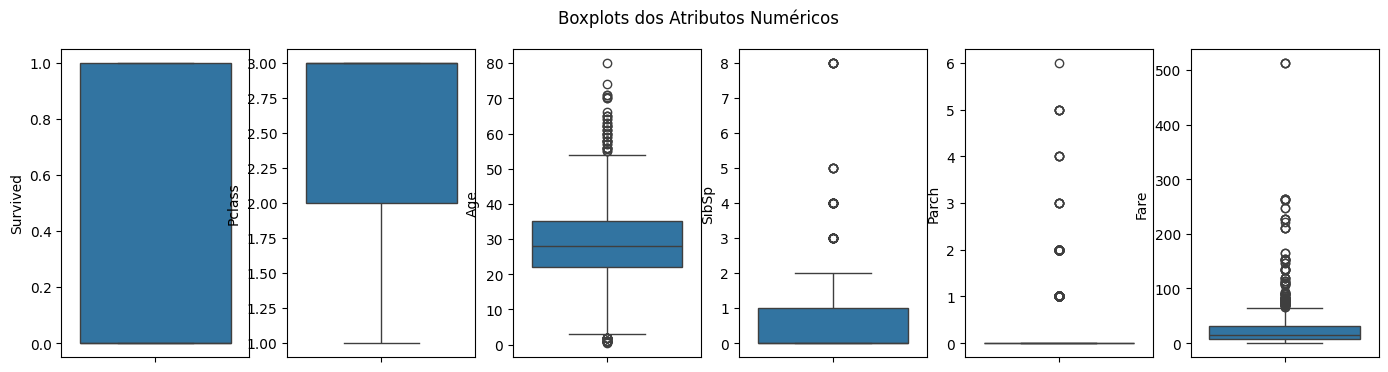

In [708]:
fig, ax = plt.subplots(ncols=len(numericos), nrows=1)
plt.suptitle("Boxplots dos Atributos Numéricos")

# Gráfico para cada atributo numérico
for i in range(0, len(numericos)):
    feature = numericos[i]
    sns.boxplot(dataset[feature], ax=ax[i])

Os boxplots acima mostram ainda mais claramente a existência de outliers para Age, SibSp, Parch e Fare, principalmente para as 3 últimas. Em etapas posteriores, pode ser que seja necessário realizar algum tratamento nas instâncias que apresentam esse tipo de comportamento.

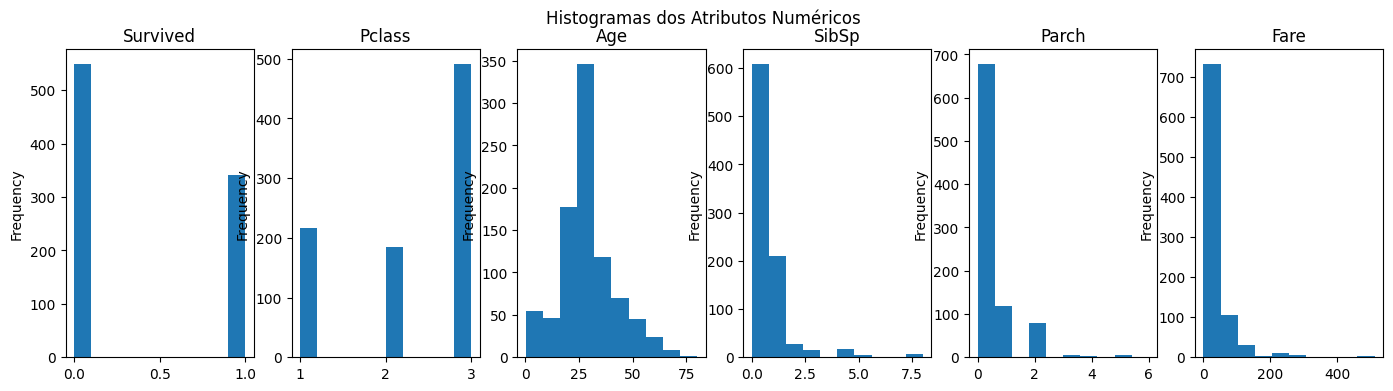

In [709]:
fig, ax = plt.subplots(ncols=len(numericos), nrows=1)
plt.suptitle("Histogramas dos Atributos Numéricos")

# Histograma para cada atributo numérico
for i in range(0, len(numericos)):
    feature = numericos[i]
    ax[i].set_title(feature)
    dataset[feature].plot(kind='hist', ax=ax[i])

Analisando as distribuições, temos que:

    Existiam mais passageiros na terceira classe do que nas outras 2
    A variável Age é a que mais se aproxima de uma Distribuição Normal
    SibSp, Parch e Fare possuem, em sua maioria, valores pequenos

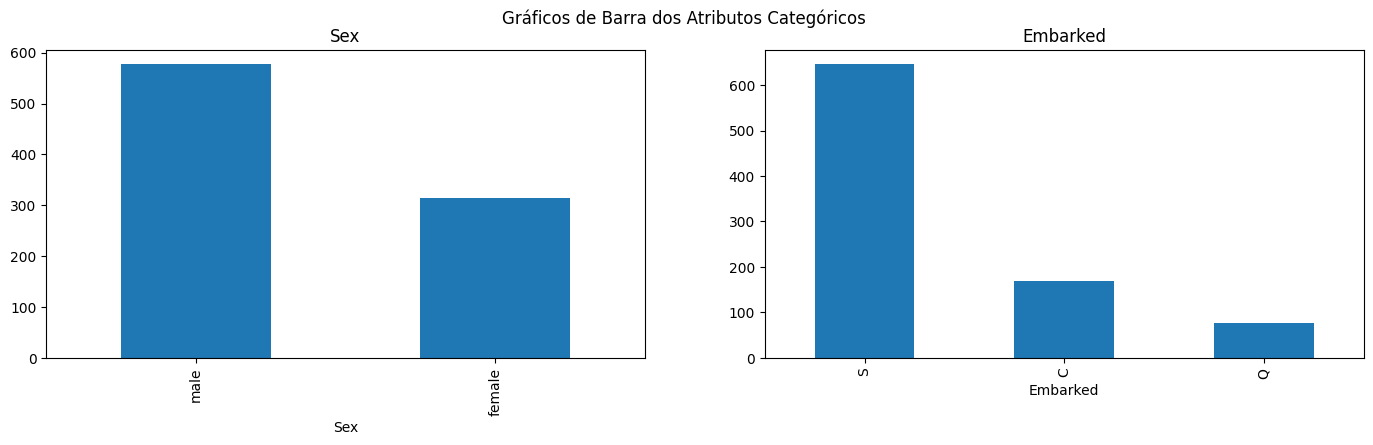

In [710]:
fig, ax = plt.subplots(ncols=len(categoricos), nrows=1)
plt.suptitle("Gráficos de Barra dos Atributos Categóricos")

# Gráfico para cada atributo categórico
for i in range(0, len(categoricos)):
    feature = categoricos[i]
    ax[i].set_title(feature)
    dataset[feature].value_counts().plot(kind='bar', ax=ax[i])

Existiam mais homens do que mulheres a bordo e a maioria dos passageiros embarcaram em "S" (Southampton)


<Axes: >

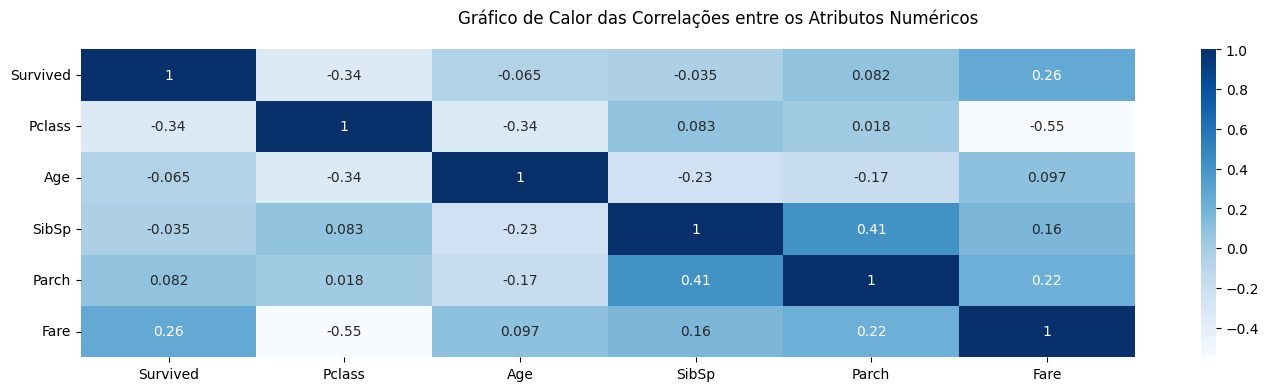

In [711]:
# Somente atributos numéricos são considerados
plt.suptitle("Gráfico de Calor das Correlações entre os Atributos Numéricos")
numeric_dataset = dataset.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_dataset.corr(), annot=True, cmap='Blues')

O gráfico de calor mostra que as variáveis mais correlacionadas são Pclass e Fare (negativamente) e SibSp e Parch (positivamente).

## Pré-Processamento

In [712]:
dataset_original.shape

(891, 12)

In [713]:
dataset_original

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [714]:
# removendo features que não serão utilizadas no treinamento
dataset = dataset_original.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [715]:
# divisão do dataset em treino e teste
train, test_split = train_test_split(dataset.copy(), test_size=0.3)

In [716]:
train.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,115
SibSp,0
Parch,0
Fare,0
Embarked,2


In [717]:
# Para as instâncias onde Age é nulo, imputar a mediana
train.loc[train['Age'].isnull(), 'Age'] = mediana_age

In [718]:
# Para as instâncias onde Embarked é nulo, imputar a moda (S)
train.loc[train['Embarked'].isnull(), 'Embarked'] = (train.mode())['Embarked'][0]

# normalizando os dados
train = pd.get_dummies(train)

# Evitar dummy trap excluindo valores de referência
train.drop(['Sex_male', 'Embarked_S'], axis=1, inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
570,1,2,62.0,0,0,10.5000,False,False,False
780,1,3,13.0,0,0,7.2292,True,True,False
728,0,2,25.0,1,0,26.0000,False,False,False
617,0,3,26.0,1,0,16.1000,True,False,False
646,0,3,19.0,0,0,7.8958,False,False,False


In [719]:
# separando o target do treinamento
X = train.drop(['Survived'], axis=1)
y = train['Survived']

### Treinamento do modelo - RandomForest

In [720]:
# treinamento do modelo com Random Forest
model = RandomForestClassifier(random_state=1)
model.fit(X, y)

RandomForestClassifier(random_state=1)

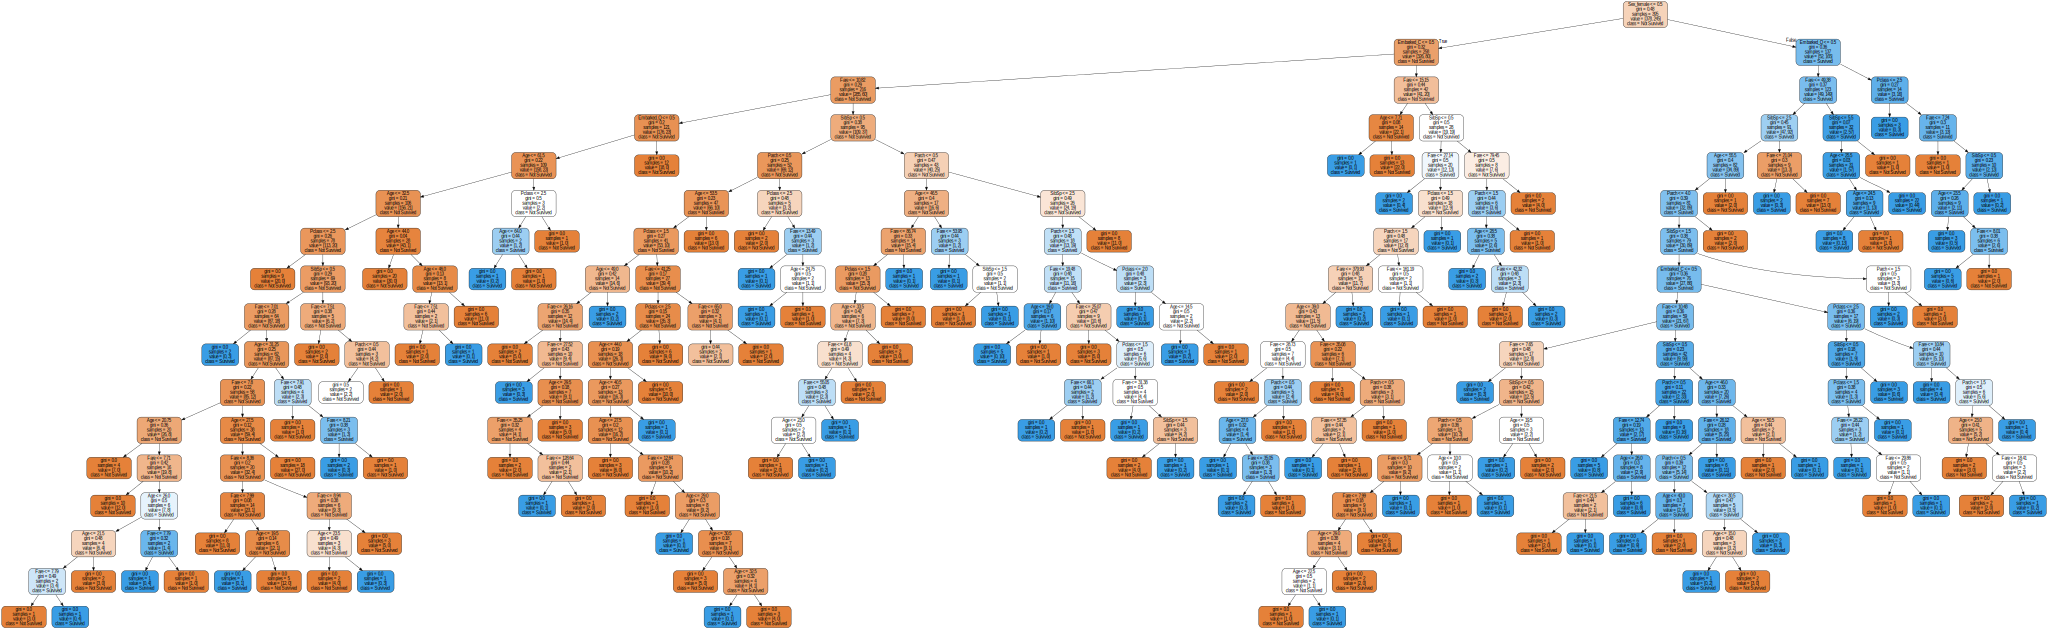

In [721]:
# Select one tree from the forest
estimator = model.estimators_[0]

# Export the tree to a DOT file
export_graphviz(estimator,
                out_file='tree.dot',
                feature_names = X.columns,
                class_names = ['Not Survived', 'Survived'],
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Convert the DOT file to a PNG image
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

[DataCamp - RandomForest](https://www.datacamp.com/tutorial/random-forests-classifier-python)

In [722]:


# Define the parameter distribution for RandomizedSearchCV
param_dist = {'n_estimators': randint(50, 500),
              'max_depth': randint(1, 20)}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=1)

# Fit RandomizedSearchCV to the training data
random_search.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x782c381bff20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x782c395db560>},
                   random_state=1)

*n_estimators* : the number of decision trees in the forest. Increasing this hyperparameter generally improves the performance of the model but also increases the computational cost of training and predicting.

*max_depth* : the maximum depth of each decision tree in the forest. Setting a higher value for max_depth can lead to overfitting while setting it too low can lead to underfitting.

### Avaliação do modelo com o dataframe de testes

In [723]:
# treinamento do modelo com Random Forest após descobrir hiperparâmetros
model = RandomForestClassifier(max_depth=6, n_estimators=452, random_state=1)
model.fit(X, y)

RandomForestClassifier(max_depth=6, n_estimators=452, random_state=1)

In [724]:
y_pred = model.predict(X)

In [725]:
# acurácia
accuracy_score(y, y_pred)

0.8796147672552167

In [726]:
mediana_age

28.0

In [727]:
# Imputar valores nulos usando padrões do conjunto de treino
test_split.loc[test_split['Age'].isnull(), 'Age'] = mediana_age
test_split.loc[test_split['Embarked'].isnull(), 'Embarked'] = 'S'

# Transformar variáveis categóricas
test_split = pd.get_dummies(test_split)
test_split.drop(['Embarked_S', 'Sex_male'], inplace=True, axis=1)

In [728]:
test_split.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
802,1,1,11.0,1,2,120.000,False,False,False
593,0,3,28.0,0,2,7.750,True,False,True
92,0,1,46.0,1,0,61.175,False,False,False
38,0,3,18.0,2,0,18.000,True,False,False
767,0,3,30.5,0,0,7.750,True,False,True


In [729]:
X_test = test_split.drop(['Survived'], axis=1)
y_test = test_split['Survived']

In [730]:
y_pred = model.predict(X_test)

In [731]:
accuracy_score(y_test, y_pred)

0.8097014925373134

Tarefa : melhorar essa acurácia dos dados de teste. accuracy_score(y_test, y_pred).

1º Troquei os valores nulos da coluna 'Age' de média para mediana.

2º Tirei a colune 'Fare', mas a acurácia caiu, por isso voltei ela denovo.

3º Usei o RandomizedSearchCV para descobrir os hiperparâmatros que me darão uma melhor acurácia que a atual, os valores que apareeram foram : max_depth=6, n_estimators=452 ; acrescentei esses hiperparâmetros ao random_state=1 e a acurácia do treinamento caiu porém do teste subiu para 0.8358

### Treinamento do modelo - KNN

In [748]:
knn = KNeighborsClassifier(n_neighbors=12, p=1)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=12, p=1)

In [747]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_knn = {'n_neighbors': randint(1, 20),
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]} # Add 'p' for Minkowski distance (1 for Manhattan, 2 for Euclidean)

# Initialize RandomizedSearchCV
random_search_knn = RandomizedSearchCV(knn, param_distributions=param_dist_knn, n_iter=10, cv=5, random_state=1)

# Fit RandomizedSearchCV to the training data
random_search_knn.fit(X, y)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x782c44c19490>,
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=1)

In [749]:
y_pred_knn = knn.predict(X_test)

In [750]:
accuracy_score(y_test, y_pred_knn)

0.7089552238805971